# 캐글 신용카드 사기 데이터

 https://www.kaggle.com/mlg-ulb/creditcardfraud

### 데이터 일차 가공 및 모델 학습/예측/평가

** 데이터 로드 **

In [7]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import VotingClassifier

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn import model_selection

from statistics import mean

df_card = pd.read_csv('./small_creditcard.csv')
df_card.head(3)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,297.0,-1.148038,0.367626,2.769717,-0.356562,-0.268456,0.323423,-0.108718,0.452755,0.166990,-0.752053,1.034453,0.563469,-0.969780,-0.203454,-0.748644,0.176892,-0.250893,-0.078208,-0.665424,-0.165654,0.063334,0.168210,-0.194521,0.228655,0.107744,0.222331,-0.109160,0.089767,6.20,0
1,118832.0,2.162760,-1.238885,0.063662,-0.912555,-1.480984,0.013461,-1.675211,0.127731,0.713710,0.689094,-1.569801,-0.777109,0.386043,-0.895883,0.694106,1.882825,-0.365570,-0.419707,0.463375,0.004118,0.375718,1.185962,0.102516,-0.684163,-0.324838,-0.046454,0.054129,-0.038738,11.99,0
2,68226.0,1.431259,-1.209961,0.773942,-1.284117,-1.906485,-0.800030,-1.230176,-0.130394,-1.548655,1.420871,-0.572030,-1.085671,0.254936,-0.422863,0.881729,-0.129313,0.394034,0.355615,-0.450581,-0.270220,-0.043408,0.194592,-0.026630,0.382732,0.316367,-0.106322,0.043092,0.032694,47.00,0


In [8]:
# 전체 데이터 모양
df_card.shape

(28924, 31)

In [10]:
# 결측치 확인 하기
total = df_card.isnull().sum()
total

Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64

0    28432
1      492
Name: Class, dtype: int64


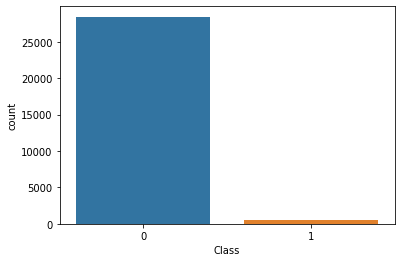

In [11]:
# 종속변수 분석(0이 1보다 훨씬 많다는 것을 알 수 있다.)
print(df_card["Class"].value_counts())
sns.countplot(df_card["Class"])

## 데이터셋 생성

In [12]:
# 원본 DataFrame은 유지하고 데이터 가공을 위한 DataFrame을 복사
df_copy = df_card.copy()
df_copy.drop('Time', axis=1, inplace=True)
df_copy


,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,-1.148038,0.367626,2.769717,-0.356562,-0.268456,0.323423,-0.108718,0.452755,0.166990,-0.752053,1.034453,0.563469,-0.969780,-0.203454,-0.748644,0.176892,-0.250893,-0.078208,-0.665424,-0.165654,0.063334,0.168210,-0.194521,0.228655,0.107744,0.222331,-0.109160,0.089767,6.20,0
1,2.162760,-1.238885,0.063662,-0.912555,-1.480984,0.013461,-1.675211,0.127731,0.713710,0.689094,-1.569801,-0.777109,0.386043,-0.895883,0.694106,1.882825,-0.365570,-0.419707,0.463375,0.004118,0.375718,1.185962,0.102516,-0.684163,-0.324838,-0.046454,0.054129,-0.038738,11.99,0
2,1.431259,-1.209961,0.773942,-1.284117,-1.906485,-0.800030,-1.230176,-0.130394,-1.548655,1.420871,-0.572030,-1.085671,0.254936,-0.422863,0.881729,-0.129313,0.394034,0.355615,-0.450581,-0.270220,-0.043408,0.194592,-0.026630,0.382732,0.316367,-0.106322,0.043092,0.032694,47.00,0
3,-0.904846,1.972067,-0.640908,-0.592312,2.583306,-0.339718,1.623795,0.032554,-1.312951,-2.526887,1.339570,-0.018091,0.568721,-3.608999,-0.537181,1.833423,1.601944,1.697607,-1.900715,-0.069056,-0.163554,-0.494736,-0.713285,-1.667608,1.104233,-0.443749,0.041098,0.103754,3.49,0
4,-0.580885,1.269135,1.173819,0.013105,-0.050119,-0.992948,0.711062,-0.054799,-0.174265,-0.201470,-0.227284,-0.182414,-0.084298,-0.460413,0.933400,0.375760,0.007957,-0.126950,-0.116895,0.224314,-0.299015,-0.726440,0.018381,0.319000,-0.110297,0.078397,0.355737,0.154326,8.92,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28919,-0.584838,0.707524,0.206116,-0.655352,0.483038,-0.930851,0.839409,-0.171791,-0.040006,0.115162,0.840832,0.711381,-0.338107,0.246548,-1.035197,0.070942,-0.642155,-0.272854,0.211609,-0.205460,-0.197186,-0.438167,0.294931,0.060381,-0.517084,0.089154,-0.125381,0.085707,2.68,0
28920,-0.391432,0.666568,0.319157,-0.655617,1.451894,-0.850163,1.087021,-0.274611,-0.105761,-0.960113,-0.933181,-0.921178,-1.133777,-0.919331,-0.060529,0.264652,0.334794,-0.017223,-0.024027,0.013656,-0.331086,-0.905964,-0.070994,0.454476,-0.331515,0.121960,-0.108407,-0.054006,1.98,0
28921,1.216427,-0.493720,0.868046,-0.692253,-1.332927,-0.822326,-0.653288,0.013846,1.994663,-1.050031,-0.636871,0.225129,-0.927995,0.003446,1.384620,-0.413257,-0.103127,0.467672,0.474292,-0.150241,0.135737,0.591296,-0.135473,0.392917,0.588397,-0.528992,0.086007,0.033559,16.95,0
28922,1.081374,-0.173686,-0.125075,1.574406,1.677616,4.428573,-1.069906,1.151166,-0.026695,0.530029,-0.728483,-0.008559,-0.004328,-0.260574,-0.108290,0.954300,-0.913116,0.255884,-0.486136,0.065371,-0.108454,-0.426971,-0.035571,0.994900,0.437947,-0.033462,0.035461,0.037910,51.93,0


In [19]:
# train_test_split() 함수를 이용하여 데이터를 train, test 데이터를 생성한다.
# 이때, stratify=y_target 옵션을 사용하면, train과 test 데이터에서 레이블 값의 비율을 일정하게 할 수 있다.

from sklearn.model_selection import train_test_split

X_features = df_copy.iloc[:, :-1] #피처들의 모음, class 레이블만 빠짐
y_target = df_copy.iloc[:, -1] #레이블 값만 존재 class

# train_test_split( )으로 학습과 테스트 데이터 분할. stratify=y_target으로 Stratified 기반 분할
#imbalanced data에는 stratify=y_target 옵션 필수 - 비율 맞춰줌
X_train, X_test, y_train, y_test = train_test_split(X_features, y_target, test_size=0.3, random_state=0, stratify=y_target)

print('학습 데이터 레이블 값 비율')
print(y_train.value_counts()/y_train.shape[0] * 100)
print('테스트 데이터 레이블 값 비율')
print(y_test.value_counts()/y_test.shape[0] * 100)

학습 데이터 레이블 값 비율
0    98.300899
1     1.699101
Name: Class, dtype: float64
테스트 데이터 레이블 값 비율
0    98.294538
1     1.705462
Name: Class, dtype: float64


## 모델을 평가하는 함수 작성
사이킷런에서 제공하는 다양한 모델평가 함수를 사용 할 수 있다.
불균형 데이터의 경우, roc_auc, average_precision, F1 등을 주로 사용한다.

참고: 
https://scikit-learn.org/stable/modules/classes.html#sklearn-metrics-metrics

In [20]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_auc_score, average_precision_score

# 모델을 평가하는 함수
def get_clf_eval(y_test, pred=None, pred_proba=None):
    accuracy = accuracy_score(y_test , pred)
    precision = precision_score(y_test , pred)
    recall = recall_score(y_test , pred)
    f1 = f1_score(y_test,pred)
    roc_auc = roc_auc_score(y_test, pred_proba)
    ap = average_precision_score(y_test, pred_proba)
    print(f"AP: {ap:0.3f}, AUC: {roc_auc:0.3f}, F1: {f1:0.3f}")

    

## 모델 생성, 학습, 평가

In [21]:
models = {
    "Ran":RandomForestClassifier(),
    "KNN":KNeighborsClassifier(),
    "Log":LogisticRegression(),
    "GBC":GradientBoostingClassifier(),
    "XGB":XGBClassifier(),
    "LGB":LGBMClassifier(),
    "SVC":SVC(probability=True),
    "Ada":AdaBoostClassifier(),
    "GNB":GaussianNB(),
    "Bag":BaggingClassifier(),
}


for model_name, model in models.items():
    print(model_name, end=" ")
    model.fit(X_train, y_train)
    pred = model.predict(X_test)
    pred_proba = model.predict_proba(X_test)[:, 1]
    get_clf_eval(y_test, pred, pred_proba)
    

Ran AP: 0.895, AUC: 0.973, F1: 0.890
KNN AP: 0.775, AUC: 0.917, F1: 0.820
Log AP: 0.866, AUC: 0.968, F1: 0.884
GBC AP: 0.700, AUC: 0.964, F1: 0.831
XGB AP: 0.904, AUC: 0.979, F1: 0.890
LGB AP: 0.899, AUC: 0.974, F1: 0.903
SVC AP: 0.849, AUC: 0.984, F1: 0.606
Ada AP: 0.892, AUC: 0.955, F1: 0.866
GNB AP: 0.506, AUC: 0.968, F1: 0.547
Bag AP: 0.862, AUC: 0.948, F1: 0.882


### 중요 데이터 분포도 변환 후 모델 학습/예측/평가


** 중요 feature의 분포도 확인 **

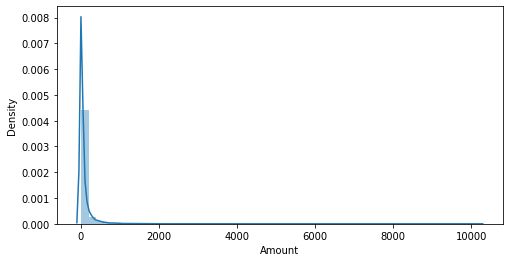

In [22]:
import seaborn as sns

plt.figure(figsize=(8, 4))
sns.distplot(df_card['Amount'])

#### 1. StandardScaler를 이용하여 Amount 피처 변환

Ran AP: 0.893, AUC: 0.973, F1: 0.890
KNN AP: 0.841, AUC: 0.938, F1: 0.876
Log AP: 0.871, AUC: 0.977, F1: 0.887
GBC AP: 0.681, AUC: 0.964, F1: 0.832
XGB AP: 0.904, AUC: 0.979, F1: 0.890
LGB AP: 0.901, AUC: 0.974, F1: 0.900
SVC AP: 0.842, AUC: 0.952, F1: 0.876
Ada AP: 0.892, AUC: 0.955, F1: 0.866
GNB AP: 0.508, AUC: 0.968, F1: 0.547
Bag AP: 0.860, AUC: 0.938, F1: 0.884


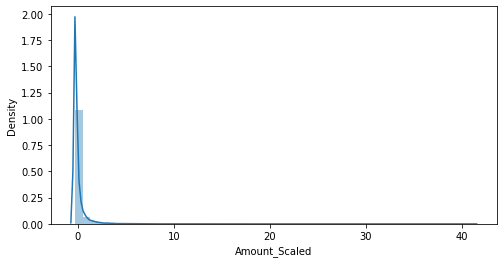

In [24]:
df_copy = df_card.copy()
scaler = StandardScaler()
amount_n = scaler.fit_transform(df_copy['Amount'].values.reshape(-1, 1))

# 변환된 Amount를 Amount_Scaled로 피처명 변경후 DataFrame맨 앞 컬럼으로 입력
df_copy.insert(0, 'Amount_Scaled', amount_n)

plt.figure(figsize=(8, 4))
sns.distplot(df_copy['Amount_Scaled'])

# 기존 Time, Amount 피처 삭제
df_copy.drop(['Time','Amount'], axis=1, inplace=True)

X_features = df_copy.iloc[:, :-1] #피처들의 모음, class 레이블만 빠짐
y_target = df_copy.iloc[:, -1] #레이블 값만 존재 class

# train_test_split( )으로 학습과 테스트 데이터 분할. stratify=y_target으로 Stratified 기반 분할
#imbalanced data에는 stratify=y_target 옵션 필수 - 비율 맞춰줌
X_train, X_test, y_train, y_test = train_test_split(X_features, y_target, test_size=0.3, random_state=0, stratify=y_target)


# 모델 학습, 평가
models = {
    "Ran":RandomForestClassifier(),
    "KNN":KNeighborsClassifier(),
    "Log":LogisticRegression(),
    "GBC":GradientBoostingClassifier(),
    "XGB":XGBClassifier(),
    "LGB":LGBMClassifier(),
    "SVC":SVC(probability=True),
    "Ada":AdaBoostClassifier(),
    "GNB":GaussianNB(),
    "Bag":BaggingClassifier(),
}


for model_name, model in models.items():
    print(model_name, end=" ")
    model.fit(X_train, y_train)
    pred = model.predict(X_test)
    pred_proba = model.predict_proba(X_test)[:, 1]
    get_clf_eval(y_test, pred, pred_proba)
    

**Amount 표준화 - 큰 변화 없음**

#### 2. 로그 변환을 Amount 피처 변환

로그 변환을 하면 정규분포에 가까워진다.

일반적으로 원본 값에 1을 더한 후 로그로 변환하는 것이 많이 사용된다.

참고: https://rfriend.tistory.com/295

치우쳐진 데이터 -> normal (정규) 분포로

Ran AP: 0.898, AUC: 0.977, F1: 0.890
KNN AP: 0.837, AUC: 0.938, F1: 0.876
Log AP: 0.870, AUC: 0.976, F1: 0.890
GBC AP: 0.689, AUC: 0.966, F1: 0.847
XGB AP: 0.904, AUC: 0.979, F1: 0.890
LGB AP: 0.899, AUC: 0.974, F1: 0.903
SVC AP: 0.846, AUC: 0.956, F1: 0.876
Ada AP: 0.892, AUC: 0.955, F1: 0.866
GNB AP: 0.502, AUC: 0.969, F1: 0.540
Bag AP: 0.875, AUC: 0.945, F1: 0.887


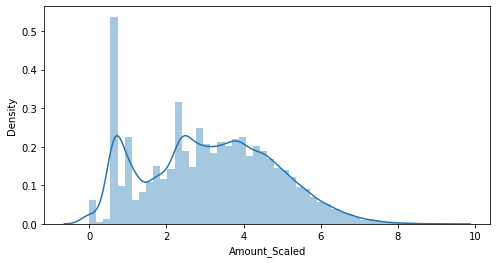

In [25]:
df_copy = df_card.copy()
amount_n = np.log1p(df_copy['Amount']) #log1p - 1 더하고 로그 취하는 함수

# 변환된 Amount를 Amount_Scaled로 피처명 변경후 DataFrame맨 앞 컬럼으로 입력
df_copy.insert(0, 'Amount_Scaled', amount_n)

# 기존 Time, Amount 피처 삭제
df_copy.drop(['Time','Amount'], axis=1, inplace=True)

plt.figure(figsize=(8, 4))
sns.distplot(df_copy['Amount_Scaled'])

X_features = df_copy.iloc[:, :-1] #피처들의 모음, class 레이블만 빠짐
y_target = df_copy.iloc[:, -1] #레이블 값만 존재 class

# train_test_split( )으로 학습과 테스트 데이터 분할. stratify=y_target으로 Stratified 기반 분할
#imbalanced data에는 stratify=y_target 옵션 필수 - 비율 맞춰줌
X_train, X_test, y_train, y_test = train_test_split(X_features, y_target, test_size=0.3, random_state=0, stratify=y_target)

# 모델 학습, 평가
models = {
    "Ran":RandomForestClassifier(),
    "KNN":KNeighborsClassifier(),
    "Log":LogisticRegression(),
    "GBC":GradientBoostingClassifier(),
    "XGB":XGBClassifier(),
    "LGB":LGBMClassifier(),
    "SVC":SVC(probability=True),
    "Ada":AdaBoostClassifier(),
    "GNB":GaussianNB(),
    "Bag":BaggingClassifier(),
}


for model_name, model in models.items():
    print(model_name, end=" ")
    model.fit(X_train, y_train)
    pred = model.predict(X_test)
    pred_proba = model.predict_proba(X_test)[:, 1]
    get_clf_eval(y_test, pred, pred_proba)
    

***Amount 로그 변환 -> 별 차이 없음***

### 이상치 데이터 제거 후 모델 학습/예측/평가

** 각 피처들의 상관 관계를 시각화. 결정 레이블인 class 값과 가장 상관도가 높은 피처 추출 **

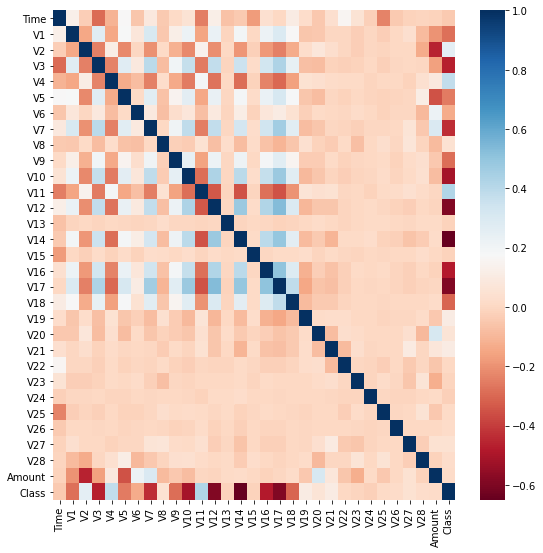

In [26]:
plt.figure(figsize=(9, 9))
corr = df_card.corr()
sns.heatmap(corr, cmap='RdBu')

** Dataframe에서 outlier에 해당하는 데이터를 필터링하기 위한 함수 생성. outlier 레코드의 index를 반환함. **

참고: IQR을 이용하여 이상치 제거

https://hwi-doc.tistory.com/entry/IQR-%EB%B0%A9%EC%8B%9D%EC%9D%84-%EC%9D%B4%EC%9A%A9%ED%95%9C-%EC%9D%B4%EC%83%81%EC%B9%98-%EB%8D%B0%EC%9D%B4%ED%84%B0Outlier-%EC%A0%9C%EA%B1%B0

In [27]:
def get_outlier(df=None, column=None, weight=1.5):
    # fraud에 해당하는 column 데이터만 추출, 1/4 분위와 3/4 분위 지점을 np.percentile로 구함. 
    sns.boxplot(x="Class", y=column, data=df)
    fraud = df[df['Class']==1][column]
    quantile_25 = np.percentile(fraud.values, 25)
    quantile_75 = np.percentile(fraud.values, 75)
    
    # IQR을 구하고, IQR에 1.5를 곱하여 최대값과 최소값 지점 구함. 
    iqr = quantile_75 - quantile_25
    iqr_weight = iqr * weight
    lowest_val = quantile_25 - iqr_weight
    highest_val = quantile_75 + iqr_weight
    
    # 최대값 보다 크거나, 최소값 보다 작은 값을 아웃라이어로 설정하고 DataFrame index 반환. 
    outlier_index = fraud[(fraud < lowest_val) | (fraud > highest_val)].index
    
    return outlier_index
    

In [34]:
np.percentile(df_card['V14'].values, 50) #중앙값 (50%에 위치한 값), 0이면 최소값, 100이면 최대값

0.03951822742964395

이상치 데이터 인덱스: Int64Index([3200, 5183, 14010, 22170], dtype='int64')


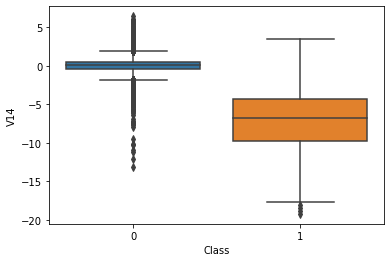

In [35]:
outlier_index = get_outlier(df=df_card, column='V14', weight=1.5)
print('이상치 데이터 인덱스:', outlier_index)

class 1이 중요

#### 이상치 제거후 모델 학습

Ran AP: 0.894, AUC: 0.972, F1: 0.896
KNN AP: 0.850, AUC: 0.948, F1: 0.883
Log AP: 0.876, AUC: 0.985, F1: 0.876
GBC AP: 0.744, AUC: 0.979, F1: 0.859
XGB AP: 0.921, AUC: 0.988, F1: 0.890
LGB AP: 0.926, AUC: 0.987, F1: 0.903
SVC AP: 0.855, AUC: 0.953, F1: 0.857
Ada AP: 0.902, AUC: 0.985, F1: 0.874
GNB AP: 0.503, AUC: 0.968, F1: 0.540
Bag AP: 0.861, AUC: 0.950, F1: 0.875


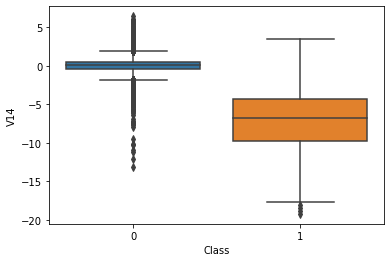

In [36]:
df_copy = df_card.copy()
amount_n = np.log1p(df_copy['Amount']) #로그변환 사용

# 변환된 Amount를 Amount_Scaled로 피처명 변경후 DataFrame맨 앞 컬럼으로 입력
df_copy.insert(0, 'Amount_Scaled', amount_n)

# 기존 Time, Amount 피처 삭제
df_copy.drop(['Time','Amount'], axis=1, inplace=True)

# 아웃라이어 제거
outlier_index = get_outlier(df=df_copy, column='V14', weight=1.5)
df_copy.drop(outlier_index, axis=0, inplace=True) #drop할 때 axis=0 : 행을 제거

# train_test_split() 함수를 이용하여 데이터를 나눈다.
X_features = df_copy.iloc[:, :-1]
y_target = df_copy.iloc[:, -1]
# train_test_split( )으로 학습과 테스트 데이터 분할. stratify=y_target으로 Stratified 기반 분할
X_train, X_test, y_train, y_test = train_test_split(X_features, y_target, test_size=0.3, random_state=0, stratify=y_target)

# 모델 학습, 평가
models = {
    "Ran":RandomForestClassifier(),
    "KNN":KNeighborsClassifier(),
    "Log":LogisticRegression(),
    "GBC":GradientBoostingClassifier(),
    "XGB":XGBClassifier(),
    "LGB":LGBMClassifier(),
    "SVC":SVC(probability=True),
    "Ada":AdaBoostClassifier(),
    "GNB":GaussianNB(),
    "Bag":BaggingClassifier(),
}


for model_name, model in models.items():
    print(model_name, end=" ")
    model.fit(X_train, y_train)
    pred = model.predict(X_test)
    pred_proba = model.predict_proba(X_test)[:, 1]
    get_clf_eval(y_test, pred, pred_proba)

### SMOTE 오버 샘플링 적용 후 모델 학습/예측/평가

** 샘플 불균형을 제거하는 방법중 하나

Ran AP: 0.924, AUC: 0.986, F1: 0.883
KNN AP: 0.692, AUC: 0.959, F1: 0.665
Log AP: 0.859, AUC: 0.985, F1: 0.523
GBC AP: 0.904, AUC: 0.989, F1: 0.687
XGB AP: 0.903, AUC: 0.987, F1: 0.702
LGB AP: 0.928, AUC: 0.989, F1: 0.862
SVC AP: 0.877, AUC: 0.987, F1: 0.696
Ada AP: 0.887, AUC: 0.982, F1: 0.591
GNB AP: 0.497, AUC: 0.969, F1: 0.523
Bag AP: 0.823, AUC: 0.967, F1: 0.785


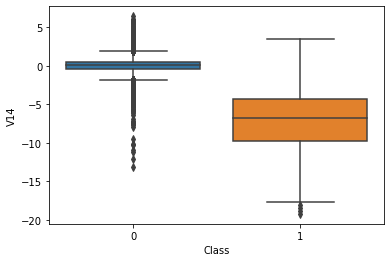

In [37]:
df_copy = df_card.copy()
amount_n = np.log1p(df_copy['Amount'])

# 변환된 Amount를 Amount_Scaled로 피처명 변경후 DataFrame맨 앞 컬럼으로 입력
df_copy.insert(0, 'Amount_Scaled', amount_n)

# 기존 Time, Amount 피처 삭제
df_copy.drop(['Time','Amount'], axis=1, inplace=True)

# 아웃라이어 제거
outlier_index = get_outlier(df=df_copy, column='V14', weight=1.5)
df_copy.drop(outlier_index, axis=0, inplace=True)

# train_test_split() 함수를 이용하여 데이터를 나눈다.
X_features = df_copy.iloc[:, :-1]
y_target = df_copy.iloc[:, -1]

# train_test_split( )으로 학습과 테스트 데이터 분할. stratify=y_target으로 Stratified 기반 분할
X_train, X_test, y_train, y_test = train_test_split(X_features, y_target, test_size=0.3, random_state=0, stratify=y_target)

# SMOTE 오버 샘플링
from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state=0)
X_train_over, y_train_over = smote.fit_sample(X_train, y_train)
X_test = X_test.to_numpy() # SMOTE를 수행하고 나면, numpy 객체가 되기 때문에, X_test 역시 numpy 객체로 변환

models = {
    "Ran":RandomForestClassifier(),
    "KNN":KNeighborsClassifier(),
    "Log":LogisticRegression(),
    "GBC":GradientBoostingClassifier(),
    "XGB":XGBClassifier(),
    "LGB":LGBMClassifier(),
    "SVC":SVC(probability=True),
    "Ada":AdaBoostClassifier(),
    "GNB":GaussianNB(),
    "Bag":BaggingClassifier(),
}


for model_name, model in models.items():
    print(model_name, end=" ")
    model.fit(X_train_over, y_train_over) # 오버 샘플링된 데이터로 학습
    pred = model.predict(X_test)
    pred_proba = model.predict_proba(X_test)[:, 1]
    get_clf_eval(y_test, pred, pred_proba)